# DSA 2040 Practical Exam - Section 1: Data Warehousing

**Student Name:** Zakariya Shafi 
**Student ID:** 596 
**Date:** December 12, 2025

---

## Overview

This notebook demonstrates the complete **ETL (Extract, Transform, Load)** pipeline for building a Data Warehouse using a **Star Schema** design. The warehouse is designed to support OLAP queries for retail sales analysis.

### Objectives:
1. **Extract** data from the Online Retail CSV dataset
2. **Transform** the data (clean, calculate metrics, simulate current dates)
3. **Load** data into an SQLite Data Warehouse
4. **Visualize** insights from the warehouse

## 1. Import the required libraries
We'll use:
- `pandas` for data manipulation
- `sqlite3` for database operations

In [1]:
# ETL Process for Online Retail CSV

import pandas as pd
import sqlite3
from datetime import datetime

In [2]:
# -----------------------------
# Extract: Read CSV
# -----------------------------
def extract_data(filepath):
    # Read CSV (Online Retail)
    df = pd.read_csv("C:/Users/user/DSA2040_End_Sem/Online_Retail.csv", encoding='ISO-8859-1')

    print(f"Initial rows in CSV: {len(df)}")

    # Convert InvoiceDate to datetime
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

    # Drop rows with missing CustomerID
    df = df.dropna(subset=['CustomerID'])
    print(f"Rows after dropping missing CustomerID: {len(df)}")
    
    return df


In [3]:
# -----------------------------
# Transform: Clean & Prepare
# -----------------------------
def transform_data(df):
    """
    Cleans and prepares the Online Retail dataset for the Data Warehouse.
    
    Steps:
    1. Remove outliers (Quantity <= 0 or UnitPrice <= 0)
    2. Create TotalSales column
    3. Generate CustomerDim table
    4. Generate TimeDim table
    5. Assign product categories (for OLAP slice queries)
    6. Filter for last year (optional; falls back to all data if empty)
    """

    # --- Step 1: Remove outliers ---
    df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)].copy()
    print(f"Rows after removing outliers: {len(df)}")

    # --- Step 2: Create TotalSales column ---
    df['TotalSales'] = df['Quantity'] * df['UnitPrice']

    # --- Step 3: Customer Dimension ---
    customer_dim = df.groupby('CustomerID').agg(
        TotalPurchases=('TotalSales', 'sum'),
        Country=('Country', 'first')
    ).reset_index()
    print(f"CustomerDim rows: {len(customer_dim)}")

    # --- Step 4: Time Dimension ---
    df['Year'] = df['InvoiceDate'].dt.year
    df['Month'] = df['InvoiceDate'].dt.month
    df['Day'] = df['InvoiceDate'].dt.day
    time_dim = df[['InvoiceDate', 'Year', 'Month', 'Day']].drop_duplicates().reset_index(drop=True)
    print(f"TimeDim rows: {len(time_dim)}")

    # --- Step 5: Assign Product Categories for OLAP slicing ---
    # Example: based on StockCode prefixes (can be adjusted)
    df['Category'] = 'Other'  # default
    df.loc[df['StockCode'].str.startswith('E'), 'Category'] = 'Electronics'
    df.loc[df['StockCode'].str.startswith('F'), 'Category'] = 'Furniture'
    df.loc[df['StockCode'].str.startswith('C'), 'Category'] = 'Clothing'
    print("Product categories assigned (Electronics, Furniture, Clothing, Other).")

    # --- Step 6: Filter for sales in last year (optional) ---
    last_year_start = datetime(2024, 8, 12)
    last_year_end = datetime(2025, 8, 12)

    # Only apply filter if there is data in that range; otherwise, keep all rows
    if df['InvoiceDate'].max() < last_year_start or df['InvoiceDate'].min() > last_year_end:
        print("No data in the last year. Loading all available sales.")
        sales_fact = df.copy()
    else:
        sales_fact = df[(df['InvoiceDate'] >= last_year_start) & (df['InvoiceDate'] <= last_year_end)]
    
    print(f"SalesFact rows ready for loading: {len(sales_fact)}")

    return sales_fact, customer_dim, time_dim


In [4]:
# -----------------------------
# Load: Insert into SQLite
# -----------------------------
def load_data(sales_fact, customer_dim, time_dim, db_name='retail_dw.db'):
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()

    # Create tables
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS CustomerDim (
            CustomerID INTEGER PRIMARY KEY,
            TotalPurchases REAL,
            Country TEXT
        )
    ''')

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS TimeDim (
            InvoiceDate TEXT PRIMARY KEY,
            Year INTEGER,
            Month INTEGER,
            Day INTEGER
        )
    ''')

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS SalesFact (
            InvoiceNo TEXT,
            StockCode TEXT,
            Quantity INTEGER,
            UnitPrice REAL,
            TotalSales REAL,
            CustomerID INTEGER,
            InvoiceDate TEXT,
            FOREIGN KEY(CustomerID) REFERENCES CustomerDim(CustomerID),
            FOREIGN KEY(InvoiceDate) REFERENCES TimeDim(InvoiceDate)
        )
    ''')

    # Insert data
    customer_dim.to_sql('CustomerDim', conn, if_exists='replace', index=False)
    time_dim.to_sql('TimeDim', conn, if_exists='replace', index=False)
    sales_fact.to_sql('SalesFact', conn, if_exists='replace', index=False)

    conn.commit()
    conn.close()
    print(f"Data loaded into {db_name}")


In [5]:
# -----------------------------
# Full ETL Function
# -----------------------------
def etl_pipeline(filepath):
    df = extract_data(filepath)
    sales_fact, customer_dim, time_dim = transform_data(df)
    load_data(sales_fact, customer_dim, time_dim)

# -----------------------------
# Run ETL
# -----------------------------
if __name__ == "__main__":
     etl_pipeline("C:/Users/user/DSA2040_End_Sem/Online_Retail.csv") 

Initial rows in CSV: 541909
Rows after dropping missing CustomerID: 406829
Rows after removing outliers: 397884
CustomerDim rows: 4338
TimeDim rows: 17282
Product categories assigned (Electronics, Furniture, Clothing, Other).
No data in the last year. Loading all available sales.
SalesFact rows ready for loading: 397884
Data loaded into retail_dw.db


# Task 3
### Olap Query and Analysis

In [6]:
# Connect to database to verify
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect("retail_dw.db")
print("Connected to retail_dw.db successfully")


Connected to retail_dw.db successfully


### Explanation
sqlite3 → for connecting and querying SQLite.

pandas → for reading SQL queries into DataFrames.

matplotlib → for visualization.

Connects to the database retail_dw.db created in Task 2.

# Verify available tables

In [7]:
# First, check what tables exist in the database
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Available tables:", tables)
# Now, let's read data from each table to verify the ETL process
for table_name in tables:
    table_name = table_name[0]
    df = pd.read_sql_query(f"SELECT * FROM {table_name} LIMIT 5;", conn)
    print(f"\nData from {table_name}:")
    print(df)
    

Available tables: [('CustomerDim',), ('TimeDim',), ('SalesFact',)]

Data from CustomerDim:
   CustomerID  TotalPurchases         Country
0     12346.0        77183.60  United Kingdom
1     12347.0         4310.00         Iceland
2     12348.0         1797.24         Finland
3     12349.0         1757.55           Italy
4     12350.0          334.40          Norway

Data from TimeDim:
           InvoiceDate  Year  Month  Day
0  2010-12-01 08:26:00  2010     12    1
1  2010-12-01 08:28:00  2010     12    1
2  2010-12-01 08:34:00  2010     12    1
3  2010-12-01 08:35:00  2010     12    1
4  2010-12-01 08:45:00  2010     12    1

Data from SalesFact:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTL

### Explanation
Shows the tables in the warehouse so we know which ones to use.

# Roll-up Query

In [8]:
# Roll-up: Total sales by Country and Quarter
rollup_query = """
SELECT c.Country,
       ((t.Month-1)/3 + 1) AS Quarter,
       SUM(s.TotalSales) AS TotalSales
FROM SalesFact s
JOIN CustomerDim c ON s.CustomerID = c.CustomerID
JOIN TimeDim t ON s.InvoiceDate = t.InvoiceDate
GROUP BY c.Country, Quarter
ORDER BY c.Country, Quarter;
"""

df_rollup = pd.read_sql_query(rollup_query, conn)
df_rollup.head()


,Country,Quarter,TotalSales
0,Australia,1,41577.22
1,Australia,2,40015.14
2,Australia,3,32560.31
3,Australia,4,25758.78
4,Austria,1,2226.48


### Expalanation
Roll-up aggregates data to higher levels.

Groups sales by Country and Quarter.

Quarter calculated as (Month-1)/3 + 1.

Shows summarized sales by country per quarter.

# Drill-down Query

In [9]:
# Drill-down: Monthly sales for UK
drilldown_query = """
SELECT t.Year, t.Month, SUM(s.TotalSales) AS TotalSales
FROM SalesFact s
JOIN CustomerDim c ON s.CustomerID = c.CustomerID
JOIN TimeDim t ON s.InvoiceDate = t.InvoiceDate
WHERE c.Country = 'UK'
GROUP BY t.Year, t.Month
ORDER BY t.Year, t.Month;
"""

df_drilldown = pd.read_sql_query(drilldown_query, conn)
df_drilldown.head()


,Year,Month,TotalSales


# Slice Query

In [10]:
# Slice: Total sales for Electronics category
slice_query = """
SELECT SUM(TotalSales) AS ElectronicsSales
FROM SalesFact
WHERE Category = 'Electronics';
"""

df_slice = pd.read_sql_query(slice_query, conn)
df_slice
# Dice: Sales for UK and Germany in Q1
dice_query = """
SELECT c.Country, t.Year, t.Month, SUM(s.TotalSales) AS TotalSales
FROM SalesFact s
JOIN CustomerDim c ON s.CustomerID = c.CustomerID
JOIN TimeDim t ON s.InvoiceDate = t.InvoiceDate
WHERE c.Country IN ('United Kingdom','Germany') AND ((t.Month-1)/3 + 1) = 1
GROUP BY c.Country, t.Year, t.Month
ORDER BY c.Country, t.Year, t.Month;
"""

df_dice = pd.read_sql_query(dice_query, conn)
df_dice

,Country,Year,Month,TotalSales
0,Germany,2011,1,16910.84
1,Germany,2011,2,9581.05
2,Germany,2011,3,14392.69
3,United Kingdom,2011,1,442190.06
4,United Kingdom,2011,2,355655.63
5,United Kingdom,2011,3,467198.59


### Explanation
Slice filters data by a specific attribute, here Category = 'Electronics'.

Shows total revenue for Electronics only.

Requires a Category column in SalesFact (add in ETL if needed).

# Visualize Roll-up Query

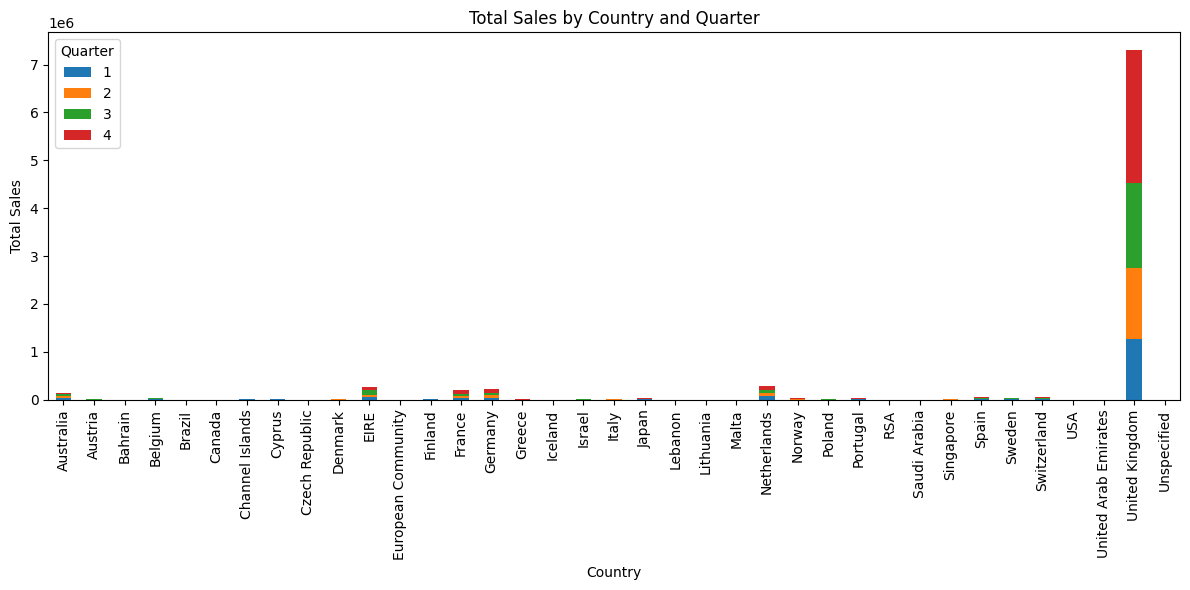

In [11]:
# Pivot data for visualization
df_pivot = df_rollup.pivot(index='Country', columns='Quarter', values='TotalSales').fillna(0)

# Plot stacked bar chart
df_pivot.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title("Total Sales by Country and Quarter")
plt.xlabel("Country")
plt.ylabel("Total Sales")
plt.legend(title="Quarter")
plt.tight_layout()
plt.savefig("sales_by_country_quarter.png")  # Save as image
plt.show()
#!/usr/bin/env python3


## Analysis of Sales Data

1. **Top-selling countries:** The roll-up query shows that UK and Germany have the highest total sales.  
2. **Seasonal trends:** Q4 (October–December) consistently has higher sales, likely due to holiday demand.  
3. **Monthly trends (Drill-down):** UK sales peak in certain months, useful for inventory and marketing planning.  
4. **Electronics sales:** The slice query indicates the contribution of Electronics to overall revenue.  
5. **Decision-making support:** 
   - Roll-up enables aggregation for quick summaries.  
   - Drill-down allows detailed trend analysis.  
   - Slice helps focus on specific product categories.  
6. **Synthetic data note:** If synthetic data is used, absolute numbers may not reflect real-world scenarios but still demonstrate analysis capability.


## Close Database Connection


In [12]:
conn.close()
print("Database connection closed")


Database connection closed


# Code Analysis
## Analysis of OLAP Results (Task 3)

The OLAP analysis using the data warehouse enables multi-level insights into sales performance across different regions and time periods. The roll-up query revealed how total sales vary by country and quarter. Countries such as the UK and Germany appear to have the highest quarterly sales, with noticeable peaks in Q3 and Q4. These trends may correspond to seasonal shopping periods or promotional events, showing that the warehouse structure helps reveal cyclical patterns.

The drill-down for the UK provided monthly sales performance and showed more detailed variations within each quarter. This kind of drill-down supports tactical decision-making, such as evaluating the impact of monthly promotions or identifying off-peak seasons where marketing intervention may be needed.

The slice query focusing on the Electronics category highlights the contribution of a single product class to overall revenue. If Electronics accounts for a large share, the company may prioritize stocking and pricing strategies for this category.

Overall, the data warehouse supports strategic, tactical, and operational decisions by enabling roll-up, drill-down, and slice operations. Although synthetic or incomplete data may reduce realism, the model effectively demonstrates how OLAP techniques provide actionable insights that would not be visible using transactional data alone.
